In [1]:
import os

#Change working directory to /Users/albertvong/Documents/Argonne/PtychoPINN/
os.chdir('/home/av_linux/PtychoPINN')

In [2]:
import numpy as np
import importlib

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset

import ptycho.tf_helper as tf_hh
import ptycho_torch.helper as pt_hh

import matplotlib.pyplot as plt


2024-10-15 09:28:24.459927: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 09:28:24.459997: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 09:28:24.501082: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 09:28:24.590723: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 09:28:25.764862: W tensorflow/compiler/tf2

No GPU found, using CPU instead.
1 items had no tests:
    __main__
0 tests in 1 items.
0 passed and 0 failed.
Test passed.


/root/miniconda3/envs/ptychopinn_ptychodus_pytorch/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
def plot_pt_and_tf(pt_version, tf_version):
    #Plot two plots side by side
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    pt_plot = pt_version
    tf_plot = tf_version
    diff_plot = pt_plot - tf_plot
    # Plot the first plot on the left
    axs[0].imshow(pt_plot)
    axs[0].set_title('pytorch')
    axs[1].imshow(tf_plot)
    axs[1].set_title('tensorflow')
    axs[2].imshow(diff_plot)
    axs[2].set_title('difference')

# We'll be using a random set of tensors to check if the functionalities of the forward model for both tensorflow and pytorch are consistent.

## All tensorflow functions without assertions

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda

In [5]:
reassemble_patches_tf = Lambda(lambda x: tf_hh.reassemble_patches(x[0], fn_reassemble_real=tf_hh.mk_reassemble_position_real(x[1])))

In [6]:
gridsize = 2

In [7]:
def extract_patches_position(imgs: tf.Tensor, offsets_xy: tf.Tensor, jitter: float = 0.) -> tf.Tensor:
    """
    Expects offsets_xy in channel format.

    imgs must be in flat format with a single image per solution region, i.e.
    (batch size, M, M, 1) where M = N + some padding size.

    Returns shifted images in channel format, cropped symmetrically

    no negative sign
    """
    if  imgs.get_shape()[0] is not None:
        assert int(imgs.get_shape()[0]) == int(offsets_xy.get_shape()[0])
    assert int(imgs.get_shape()[3]) == 1
    assert int(offsets_xy.get_shape()[2]) == 2
    assert int(imgs.get_shape()[3]) == 1
    gridsize = 2
    assert int(offsets_xy.get_shape()[3]) == gridsize**2
    offsets_flat = tf_hh.flatten_offsets(offsets_xy)
    stacked = tf.repeat(imgs, gridsize**2, axis = 3)
    flat_padded = tf_hh._channel_to_flat(stacked)
    channels_translated = tf_hh.trim_reconstruction(
        tf_hh.Translation()([flat_padded, offsets_flat, jitter]))
    return channels_translated

## All pytorch setup

In [8]:
from ptycho_torch.config_params import TrainingConfig, DataConfig, ModelConfig

In [9]:
data_config_default = {
    'nphotons': 1e5,
    'N': 128,
    'C': 4,
    'K': 6,
    'n_subsample': 10,
    'grid_size': (2,2),
    'probe_dir_get': True,
}


model_config_default = {
    'intensity_scale_trainable': True,
    'max_position_jitter': 10, #Random jitter for translation (helps make model more robust)
    'n_filters_scale': 2, #Shrinking factor for channels
    'intensity_scale': 15000.0, #General intensity scale guess, this can be trainable. Needs to be float
    'object.big': True, #True if need patch reassembly
    'probe.big': True, #True if need patch reassembly
    'offset': 4,
    'loss_function': 'Poisson'
}

training_config_default = {
    'nll': True, #Negative log likelihood for loss function
    'device': 'cuda'
}

t_config, d_config, m_config = TrainingConfig(), DataConfig(), ModelConfig()

t_config.set_settings(training_config_default)
d_config.set_settings(data_config_default)
m_config.set_settings(model_config_default)

# Setting fixed matrices to pass through forward pass

Assume that we have just passed through the autoencoder, which produces a random stack of solution regions with amplitude and phase.

In [53]:
#Fix rng seed
np.random.seed(42)

ground_truth = np.random.randn(4,4,128,128) + 1.j * np.random.randn(4,4,128,128)
ground_truth *= 200
ground_truth = ground_truth.astype('complex64')

ground_truth_fft = np.fft.fft2(ground_truth.astype(np.complex64))
ground_truth_fft = np.real(np.conj(ground_truth_fft) * ground_truth_fft) / (128 ** 2)
ground_truth_fft = np.sqrt(np.fft.fftshift(ground_truth_fft, axes=(-2,-1)))

pos = np.random.uniform(low=-20, high = 20,
                        size = (4, 4, 1, 2)).astype('float32')

In [228]:
#Calculate the normalization factor
def normalize_data(x, N: int) -> np.ndarray:
    X_full = x
    X_full_norm = ((N / 2)**2) / np.mean(tf.reduce_sum(x**2, axis=[2, 3]))
    return X_full_norm * X_full, X_full_norm

In [224]:
#Normalize the GT data
ground_truth_fft_tf, scaling_tf = normalize_data(ground_truth_fft, 128)
ground_truth_fft_pt, scaling_pt = pt_hh.normalize_data(torch.from_numpy(ground_truth_fft))


In [54]:
gt_amp = np.abs(ground_truth)
gt_phi = np.angle(ground_truth)

In [55]:
#First test with pytorch

#Convert x_amp from numpy to pytorch array

x_amp_pt = torch.from_numpy(gt_amp)
x_phi_pt = torch.from_numpy(gt_phi)

pos_pt = torch.from_numpy(pos)

x_combined_pytorch = pt_hh.combine_complex(x_amp_pt, x_phi_pt)




In [56]:
#Now test with tensorflow
#Need to re-arrange matrices so channel dimension is last (for tensorflow)
x_amp_t = np.transpose(gt_amp, (0,2,3,1))
x_phi_t = np.transpose(gt_phi, (0,2,3,1))

pos_t = np.transpose(pos, (0,2,3,1))

x_amp_tf = tf.convert_to_tensor(x_amp_t)
x_phi_tf = tf.convert_to_tensor(x_phi_t)
pos_tf = tf.convert_to_tensor(pos_t)

x_combined_tf = tf_hh.combine_complex(x_amp_tf, x_phi_tf)


In [57]:
#Check whether the combined tensors are identical first (checking combine_complex)

x_combined_pt_np = x_combined_pytorch.numpy()
x_combined_tf_np = x_combined_tf.numpy()

x_combined_tf_np = np.transpose(x_combined_tf_np, (0,3,1,2))

diff_combined_abs = np.abs(x_combined_pt_np) - np.abs(x_combined_tf_np)

np.max(diff_combined_abs)

0.00012207031

Now reassembling tensors in both pt and tf to check for equality

In [76]:
import importlib
import ptycho_torch
import ptycho
importlib.reload(ptycho_torch.helper)
importlib.reload(ptycho.tf_helper)

import ptycho_torch.helper as pt_hh
import ptycho.tf_helper as tf_hh

No GPU found, using CPU instead.


In [77]:
reassembled_patch_pytorch = pt_hh.reassemble_patches_position_real(x_combined_pytorch, pos_pt)

reassembled_patch_tf = reassemble_patches_tf([x_combined_tf, pos_tf])

In [78]:
#Checking consistency
pt_version = reassembled_patch_pytorch.numpy()
tf_version = reassembled_patch_tf.numpy()

#Transpose tf version
tf_version_np = np.transpose(tf_version, (0,3,1,2)).squeeze()

pt_version.shape, tf_version_np.shape


((4, 142, 142), (4, 142, 142))

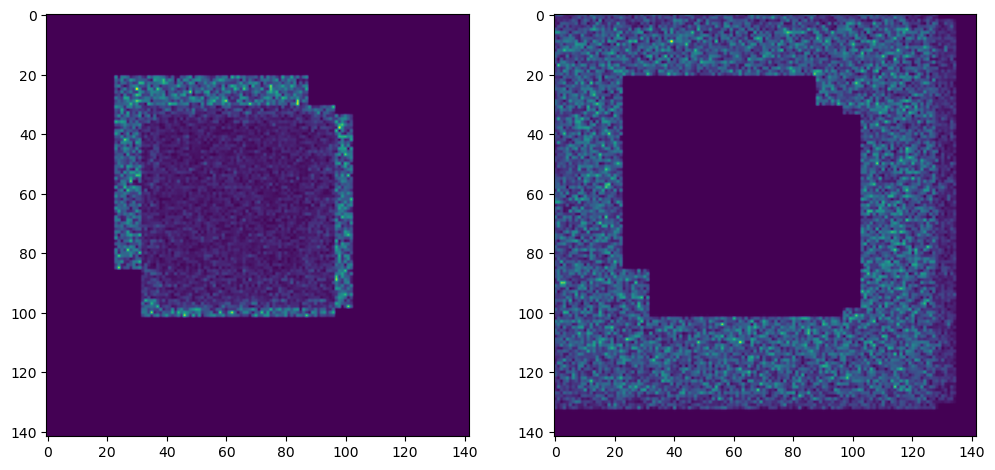

In [79]:
#Plot two plots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot the first plot on the left
axs[0].imshow(np.abs(pt_version[0]))
axs[1].imshow(np.abs(tf_version_np[0]))

In [80]:
pt_reass = np.abs(pt_version[0])
tf_reass = np.abs(tf_version_np[0])

diff = pt_reass - tf_reass

max_index = np.unravel_index(np.argmax(diff), diff.shape)

pt_reass[max_index[0], max_index[1]]

1116.728

In [261]:
np.mean(pt_reass)

179357.58

I think the differences in values my chalk up to how exactly the translation function is implemented in tensorflow vs pytorch. These qualitatively look similar to each other, but ultimately there are minute details.

It looks like here, the biggest differences exist outside the actual overlapped region. The differences get blown up due to division by a very small number (mk_norm mask) so the difference value of ~0.3-0.4 is super tiny and not relevant

## Now testing the region extraction portion of the pass

In [242]:
extracted_patches_tf = extract_patches_position(reassembled_patch_tf, pos_tf)
extracted_patches_tf = tf_hh._flat_to_channel(extracted_patches_tf)

extracted_patches_pt = pt_hh.extract_channels_from_region(reassembled_patch_pytorch[:,None,:,:], pos_pt)

In [243]:
#Again convert to numpy for comparison (cuz channel dimension mismatch)
pt_version = extracted_patches_pt.numpy()
tf_version = extracted_patches_tf.numpy()

#Transpose tf version
tf_version = np.transpose(tf_version, (0,3,1,2)).squeeze()

pt_version.shape, tf_version.shape

((4, 4, 128, 128), (4, 4, 128, 128))

Text(0.5, 1.0, 'difference')

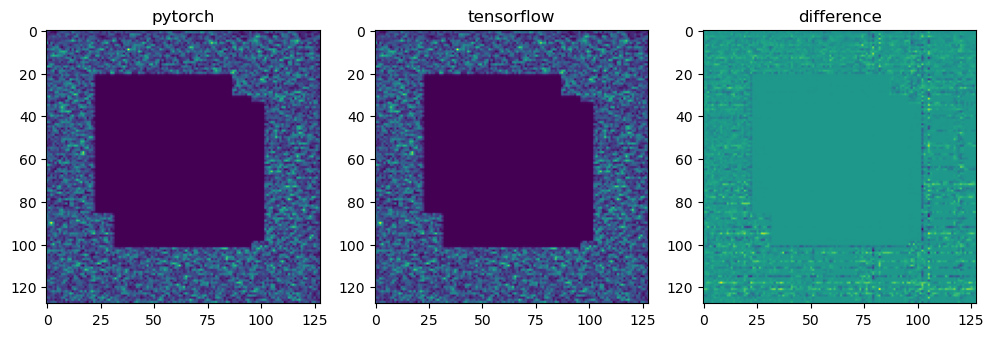

In [244]:
#Plot two plots side by side
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
pt_plot = np.abs(pt_version[0,1])
tf_plot = np.abs(tf_version[0,1])
diff_plot = pt_plot - tf_plot
# Plot the first plot on the left
axs[0].imshow(pt_plot)
axs[0].set_title('pytorch')
axs[1].imshow(tf_plot)
axs[1].set_title('tensorflow')
axs[2].imshow(diff_plot)
axs[2].set_title('difference')

## Testing out probe illumination

In [245]:
from ptycho_torch.model import ProbeIllumination



In [246]:
#Taken from model.py
class ProbeIlluminationTF(tf.keras.layers.Layer):
    def __init__(self, probe):
        super(ProbeIlluminationTF, self).__init__()
        self.w = probe
    #@tf.function
    def call(self, x):
        return self.w * x

In [247]:
#Defining probe and getting torch/tf versions
probe = np.random.randn(128,128) + 1.j * np.random.randn(128,128)
probe = probe.astype('complex64')

probe_pt = torch.from_numpy(probe)
probe_tf = tf.convert_to_tensor(probe)
tf.cast(probe_tf, tf.complex64)
probe_tf.dtype

tf.complex64

In [248]:
probe_illum_pt_module = ProbeIllumination()
probe_illum_pt = probe_illum_pt_module(extracted_patches_pt, probe_pt)

probe_illum_tf_module = ProbeIlluminationTF(probe_tf)
probe_illum_tf = probe_illum_tf_module(tf.squeeze(tf_hh._channel_to_flat(extracted_patches_tf)))


In [249]:
#Again convert to numpy for comparison (cuz channel dimension mismatch)
pt_version = probe_illum_pt[0].numpy()
tf_version = tf.reshape(probe_illum_tf,(-1, 4, 128, 128)).numpy()

pt_version.shape, tf_version.shape

((4, 4, 128, 128), (4, 4, 128, 128))

Text(0.5, 1.0, 'difference')

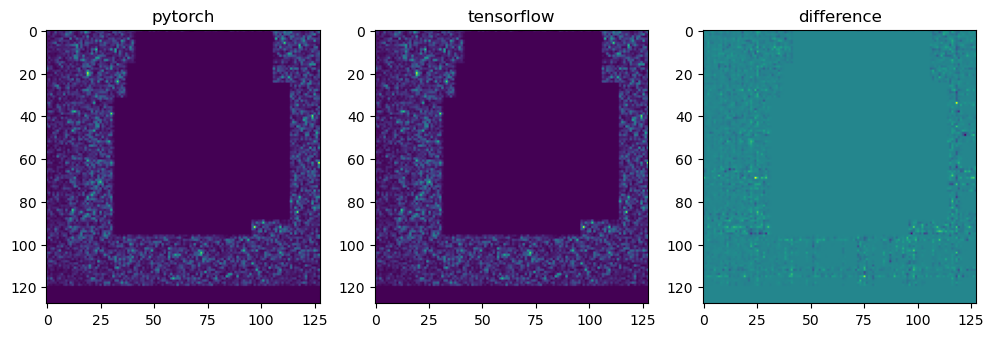

In [250]:
#Plot two plots side by side
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
pt_plot = np.abs(pt_version[2,1])
tf_plot = np.abs(tf_version[2,1])
diff_plot = pt_plot - tf_plot
# Plot the first plot on the left
axs[0].imshow(pt_plot)
axs[0].set_title('pytorch')
axs[1].imshow(tf_plot)
axs[1].set_title('tensorflow')
axs[2].imshow(diff_plot)
axs[2].set_title('difference')

## Diffraction forwarding

In [251]:
#Tensorflow
N = 128
p_and_d_tf = Lambda(lambda x: tf_hh.pad_and_diffract(x, N, N, pad=False))

In [252]:
probe_illum_tf = probe_illum_tf[:,:,:,None]
probe_illum_tf.shape

TensorShape([16, 128, 128, 1])

In [253]:
_, pad_and_diffract_tf = p_and_d_tf(probe_illum_tf)
pad_and_diffract_pt = pt_hh.pad_and_diffract(probe_illum_pt[0], pad = False)

input shape (16, 128, 128, 1)


In [254]:
pt_version = pad_and_diffract_pt[0].numpy()
tf_version = tf.reshape(tf.squeeze(pad_and_diffract_tf),(-1, 4, 128, 128)).numpy()

pt_version.shape, tf_version.shape

((4, 4, 128, 128), (4, 4, 128, 128))

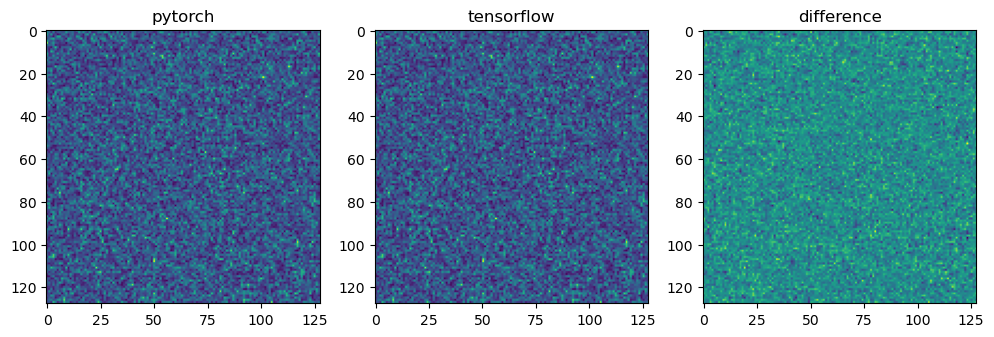

In [255]:
pt_plot, tf_plot = np.abs(pt_version[0,0]), np.abs(tf_version[0,0])
plot_pt_and_tf(pt_plot, tf_plot)

In [256]:
#Values are close enough, something weird might be happening on the side of math carryover...
pt_plot[50:55,50:55], tf_plot[50:55,50:55]

(array([[332314.56 , 204800.67 , 362008.9  , 235243.5  ,  15238.552],
        [267538.94 , 132635.4  , 140507.27 , 129738.8  , 216692.52 ],
        [303191.9  , 476457.28 , 168981.05 , 192984.9  , 294340.56 ],
        [236533.67 , 376946.1  , 323392.03 , 500753.3  , 324091.56 ],
        [411173.97 , 224245.11 , 283184.12 , 177479.89 , 414587.94 ]],
       dtype=float32),
 array([[332316.8  , 204801.56 , 362009.38 , 235245.83 ,  15238.637],
        [267539.22 , 132636.3  , 140507.75 , 129739.34 , 216693.64 ],
        [303193.1  , 476456.3  , 168982.22 , 192985.25 , 294339.94 ],
        [236535.53 , 376947.94 , 323392.3  , 500754.12 , 324092.22 ],
        [411174.94 , 224243.75 , 283186.38 , 177478.89 , 414587.84 ]],
       dtype=float32))

## Assume that the scaling layer works equally between both. Now check the poisson loss layer

In [12]:
import tensorflow_probability as tfp
tfpl = tfp.layers
tfd = tfp.distributions

In [46]:
#Create random ground truth data as well as random output data just to check equality of loss
np.random.seed(42)

ground_truth = np.random.poisson(30, (128,128))
ground_truth = ground_truth.astype('float32')
random_data = np.random.poisson(30, (4,4,128,128))
random_data = random_data.astype('float32')

#Create PT and TF versions
ground_truth_tf = tf.convert_to_tensor(ground_truth)
ground_truth_pt = torch.from_numpy(ground_truth)

random_data_tf = tf.convert_to_tensor(random_data)
random_data_pt = torch.from_numpy(random_data)



In [47]:
#Tensorflow, copied right from ptycho.model.py
dist_poisson_intensity = tfpl.DistributionLambda(lambda amplitude:
                                       (tfd.Independent(
                                           tfd.Poisson(
                                               (amplitude**2)))))
pred_intensity_sampled = dist_poisson_intensity(random_data_tf)

# Poisson distribution over expected diffraction intensity (i.e. photons per
# pixel)
negloglik = lambda x, rv_x: -rv_x.log_prob((x))
fn_poisson_nll = lambda A_target, A_pred: negloglik(A_target**2, dist_poisson_intensity(A_pred))



In [48]:
tf_loss = negloglik(ground_truth_tf,pred_intensity_sampled)
tf_loss

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([52648904., 52577840., 52434960., 52651120.], dtype=float32)>

In [49]:
#Pytorch
from ptycho_torch.model import PoissonIntensityLayer

In [52]:
poiss = PoissonIntensityLayer(random_data_pt)
torch_loss = poiss(ground_truth_pt)
torch_loss

tensor([52648908., 52577836., 52434956., 52651120.])

## Testing CUDA consistency for pytorch functions now

In [84]:
import importlib
import ptycho_torch
import ptycho
importlib.reload(ptycho_torch.helper)

import ptycho_torch.helper as pt_hh


In [85]:
reassembled_patch_pytorch = pt_hh.reassemble_patches_position_real(x_combined_pytorch.to('cuda'), pos_pt.to('cuda'))

In [86]:
reassembled_patch_pytorch.device

device(type='cuda', index=0)